## 1.초기 설정 및 Drive 마운트

In [5]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 작업 디렉토리 이동 (본인의 폴더 경로로 수정)
import os
os.chdir('/content/drive/MyDrive/DL_project2')

# 파일 확인
!ls
!ls Gillam/SLI/ | head


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DL_Project2-2.ipynb  read_cha.py
DL_Project2-3.ipynb  results_all_confusion_matrices.png
DL_Project2-4.ipynb  results_class_performance.png
DL_Project2-5.ipynb  results_confusion_matrix.png
DL_Project2.ipynb    results_metrics_comparison.png
Gillam		     results_summary.txt
gillam_dev.csv	     results_training_loss.png
gillam_test.csv      split_gillam.py
gillam_train.csv     utils.py
__pycache__
0types.txt
10f
10m
11m
5f
5m
6f
6m
7f
7m


## 2.라이브러리 임포트

In [6]:
import numpy as np
import pandas as pd
from collections import Counter
from utils import extract_utterances
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib 설정
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

print("Libraries imported successfully!")


Libraries imported successfully!


## 3.데이터 로딩 함수

In [7]:
def load_child_utterances(filename):
    """
    .cha 파일에서 아동(CHI) 발화만 추출하여 하나의 텍스트로 결합
    """
    try:
        utterances = extract_utterances(filename, ["CHI"])
        text = " ".join([utt.clean_text for utt in utterances])
        return text if text.strip() else ""
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return ""

print("Data loading function defined!")


Data loading function defined!


## 4.Vectorizer **class**

In [8]:
class SimpleVectorizer:
    """
    간단한 Bag-of-Words 벡터화
    """
    def __init__(self, max_features=1000):
        self.max_features = max_features
        self.vocab = None
        self.word_to_idx = {}

    def fit(self, texts):
        """어휘 사전 구축"""
        word_counts = Counter()
        for text in texts:
            words = text.lower().split()
            word_counts.update(words)

        # 가장 빈번한 단어들만 선택
        most_common = word_counts.most_common(self.max_features)
        self.vocab = [word for word, count in most_common]
        self.word_to_idx = {word: idx for idx, word in enumerate(self.vocab)}

        print(f"Vocabulary size: {len(self.vocab)}")
        return self

    def transform(self, texts):
        """텍스트를 벡터로 변환"""
        X = np.zeros((len(texts), len(self.vocab)))

        for i, text in enumerate(texts):
            words = text.lower().split()
            word_counts = Counter(words)

            for word, count in word_counts.items():
                if word in self.word_to_idx:
                    X[i, self.word_to_idx[word]] = count

        return X

    def fit_transform(self, texts):
        """fit + transform"""
        self.fit(texts)
        return self.transform(texts)

print("Vectorizer class defined!")


Vectorizer class defined!


## 5.logistic 회귀 모델 class

In [9]:
class LogisticRegressionNumpy:
    """
    클래스 불균형 처리를 위한 가중치 추가
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000, lambda_reg=0.1, class_weight='balanced'):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.lambda_reg = lambda_reg
        self.class_weight = class_weight
        self.weights = None
        self.bias = None
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def compute_class_weights(self, y):
        """클래스 가중치 계산"""
        if self.class_weight == 'balanced':
            n_samples = len(y)
            n_classes = 2
            n_samples_per_class = np.bincount(y.astype(int))

            # balanced weight: n_samples / (n_classes * n_samples_per_class)
            weights = n_samples / (n_classes * n_samples_per_class)
            return weights
        else:
            return np.array([1.0, 1.0])

    def fit(self, X, y):
        """클래스 가중치를 적용한 학습"""
        n_samples, n_features = X.shape

        # 클래스 가중치 계산
        class_weights = self.compute_class_weights(y)
        sample_weights = np.array([class_weights[int(label)] for label in y])

        print(f"Class weights: TD={class_weights[0]:.3f}, SLI={class_weights[1]:.3f}")

        # 가중치 초기화
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for i in range(self.n_iterations):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(linear_pred)

            # 가중치 적용된 gradient
            errors = predictions - y
            weighted_errors = errors * sample_weights

            dw = (1/n_samples) * np.dot(X.T, weighted_errors) + (self.lambda_reg * self.weights)
            db = (1/n_samples) * np.sum(weighted_errors)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # Loss 계산
            loss = -np.mean(sample_weights * (y*np.log(predictions+1e-15) + (1-y)*np.log(1-predictions+1e-15)))
            l2_penalty = (self.lambda_reg / (2*n_samples)) * np.sum(self.weights ** 2)
            total_loss = loss + l2_penalty
            self.loss_history.append(total_loss)

            if (i+1) % 100 == 0:
                print(f"Iteration {i+1}/{self.n_iterations}, Loss: {total_loss:.4f}")

    def predict_proba(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_pred)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)

print("Class-weighted Logistic Regression model defined!")


Class-weighted Logistic Regression model defined!


## 6.평가함수들

In [10]:
def accuracy(y_true, y_pred):
    """정확도"""
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred):
    """혼동 행렬"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])

def classification_metrics(y_true, y_pred):
    """분류 성능 지표 계산"""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # SLI (Positive class)
    precision_sli = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_sli = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_sli = 2 * (precision_sli * recall_sli) / (precision_sli + recall_sli) if (precision_sli + recall_sli) > 0 else 0

    # TD (Negative class)
    precision_td = tn / (tn + fn) if (tn + fn) > 0 else 0
    recall_td = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_td = 2 * (precision_td * recall_td) / (precision_td + recall_td) if (precision_td + recall_td) > 0 else 0

    # Overall accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)

    metrics = {
        'confusion_matrix': cm,
        'accuracy': acc,
        'TD': {'precision': precision_td, 'recall': recall_td, 'f1': f1_td},
        'SLI': {'precision': precision_sli, 'recall': recall_sli, 'f1': f1_sli}
    }

    return metrics

def print_metrics(metrics, dataset_name='Test'):
    """성능 지표 출력"""
    print(f"\n{'='*50}")
    print(f"{dataset_name} Set Evaluation")
    print(f"{'='*50}")
    print(f"\nAccuracy: {metrics['accuracy']:.4f}")
    print(f"\nConfusion Matrix:")
    print(f"                Predicted")
    print(f"              TD    SLI")
    print(f"Actual TD   {metrics['confusion_matrix'][0,0]:4d}  {metrics['confusion_matrix'][0,1]:4d}")
    print(f"       SLI  {metrics['confusion_matrix'][1,0]:4d}  {metrics['confusion_matrix'][1,1]:4d}")

    print(f"\nPer-Class Metrics:")
    print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print(f"{'-'*50}")
    print(f"{'TD':<10} {metrics['TD']['precision']:<12.4f} {metrics['TD']['recall']:<12.4f} {metrics['TD']['f1']:<12.4f}")
    print(f"{'SLI':<10} {metrics['SLI']['precision']:<12.4f} {metrics['SLI']['recall']:<12.4f} {metrics['SLI']['f1']:<12.4f}")

print("Evaluation functions defined!")


Evaluation functions defined!


## 7.시각화 함수 1(혼동행렬)

In [11]:
def plot_confusion_matrix(cm, dataset_name='Test', save_path=None):
    """혼동 행렬 시각화"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['TD', 'SLI'],
                yticklabels=['TD', 'SLI'],
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {dataset_name} Set', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(f'{save_path}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_all_confusion_matrices(train_cm, dev_cm, test_cm, save_path=None):
    """모든 데이터셋의 혼동 행렬을 한 번에"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for ax, cm, title in zip(axes, [train_cm, dev_cm, test_cm], ['Train', 'Dev', 'Test']):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['TD', 'SLI'],
                    yticklabels=['TD', 'SLI'],
                    ax=ax, cbar=False)
        ax.set_title(f'{title} Set', fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label' if ax == axes[0] else '')
        ax.set_xlabel('Predicted Label')

    plt.tight_layout()

    if save_path:
        plt.savefig(f'{save_path}_all_confusion_matrices.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Confusion matrix visualization functions defined!")


Confusion matrix visualization functions defined!


## 8.시각화함수 2 (성능 비교)

In [12]:
def plot_metrics_comparison(train_metrics, dev_metrics, test_metrics, save_path=None):
    """Train/Dev/Test 성능 비교 막대 그래프"""
    metrics_names = ['Accuracy', 'TD F1', 'SLI F1']

    train_values = [
        train_metrics['accuracy'],
        train_metrics['TD']['f1'],
        train_metrics['SLI']['f1']
    ]

    dev_values = [
        dev_metrics['accuracy'],
        dev_metrics['TD']['f1'],
        dev_metrics['SLI']['f1']
    ]

    test_values = [
        test_metrics['accuracy'],
        test_metrics['TD']['f1'],
        test_metrics['SLI']['f1']
    ]

    x = np.arange(len(metrics_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, train_values, width, label='Train', color='#3498db')
    ax.bar(x, dev_values, width, label='Dev', color='#2ecc71')
    ax.bar(x + width, test_values, width, label='Test', color='#e74c3c')

    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Performance Comparison Across Datasets', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])

    # 값 표시
    for i, (train, dev, test) in enumerate(zip(train_values, dev_values, test_values)):
        ax.text(i - width, train + 0.02, f'{train:.3f}', ha='center', fontsize=9)
        ax.text(i, dev + 0.02, f'{dev:.3f}', ha='center', fontsize=9)
        ax.text(i + width, test + 0.02, f'{test:.3f}', ha='center', fontsize=9)

    plt.tight_layout()

    if save_path:
        plt.savefig(f'{save_path}_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Metrics comparison visualization function defined!")


Metrics comparison visualization function defined!


## 9.시각화 함수 3( 클래스별 성능 & 학습 곡선 )

In [13]:
def plot_class_performance(metrics, dataset_name='Test', save_path=None):
    """클래스별 성능 지표 시각화"""
    classes = ['TD', 'SLI']
    precision = [metrics['TD']['precision'], metrics['SLI']['precision']]
    recall = [metrics['TD']['recall'], metrics['SLI']['recall']]
    f1 = [metrics['TD']['f1'], metrics['SLI']['f1']]

    x = np.arange(len(classes))
    width = 0.25

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(x - width, precision, width, label='Precision', color='#3498db')
    ax.bar(x, recall, width, label='Recall', color='#2ecc71')
    ax.bar(x + width, f1, width, label='F1-Score', color='#e74c3c')

    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'Per-Class Performance - {dataset_name} Set', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.0])

    # 값 표시
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        ax.text(i - width, p + 0.02, f'{p:.3f}', ha='center', fontsize=9)
        ax.text(i, r + 0.02, f'{r:.3f}', ha='center', fontsize=9)
        ax.text(i + width, f + 0.02, f'{f:.3f}', ha='center', fontsize=9)

    plt.tight_layout()

    if save_path:
        plt.savefig(f'{save_path}_class_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_training_loss(loss_history, save_path=None):
    """학습 손실 곡선"""
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, linewidth=2, color='#e74c3c')
    plt.title('Training Loss over Iterations', fontsize=14, fontweight='bold')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(f'{save_path}_training_loss.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Additional visualization functions defined!")


Additional visualization functions defined!


## 데이터 로드 및 전처리

### 0: 데이터 분할

In [14]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# 작업 디렉토리 이동
import os
os.chdir('/content/drive/MyDrive/DL_project2')

# 현재 폴더 확인
print("현재 폴더 내용:")
!ls

# Gillam 폴더 확인
print("\nGillam 폴더 구조:")
!ls Gillam/
!ls Gillam/SLI/ | head
!ls Gillam/TD/ | head


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
현재 폴더 내용:
DL_Project2-2.ipynb  read_cha.py
DL_Project2-3.ipynb  results_all_confusion_matrices.png
DL_Project2-4.ipynb  results_class_performance.png
DL_Project2-5.ipynb  results_confusion_matrix.png
DL_Project2.ipynb    results_metrics_comparison.png
Gillam		     results_summary.txt
gillam_dev.csv	     results_training_loss.png
gillam_test.csv      split_gillam.py
gillam_train.csv     utils.py
__pycache__

Gillam 폴더 구조:
0metadata.cdc  SLI  TD
0types.txt
10f
10m
11m
5f
5m
6f
6m
7f
7m
0types.txt
10f
10m
11f
11m
5f
5m
6f
6m
7f


## 0-1. split_gillam.py실행

In [15]:
# split_gillam.py가 있는지 확인
!ls split_gillam.py

# split_gillam.py 실행하여 데이터 분할
!python split_gillam.py

# 생성된 CSV 파일 확인
print("\n생성된 파일:")
!ls gillam*.csv

# 파일 내용 미리보기
print("\n=== gillam_train.csv 미리보기 ===")
!head -10 gillam_train.csv

print("\n=== gillam_dev.csv 미리보기 ===")
!head -10 gillam_dev.csv

print("\n=== gillam_test.csv 미리보기 ===")
!head -10 gillam_test.csv


split_gillam.py
No files found for SLI 5m
No files found for SLI 5f
No files found for SLI 6m
No files found for SLI 6f
No files found for SLI 7m
No files found for SLI 7m
No files found for SLI 8m
No files found for SLI 8f
No files found for SLI 9m
No files found for SLI 9f
No files found for SLI 10m
No files found for SLI 10f
No files found for SLI 11m
No files found for SLI 11f
No files found for TD 5m
No files found for TD 5f
No files found for TD 6m
No files found for TD 6f
No files found for TD 7m
No files found for TD 7m
No files found for TD 8m
No files found for TD 8f
No files found for TD 9m
No files found for TD 9f
No files found for TD 10m
No files found for TD 10f
No files found for TD 11m
No files found for TD 11f
Traceback (most recent call last):
  File "/content/drive/MyDrive/DL_project2/split_gillam.py", line 30, in <module>
    df_all = pd.concat(dfs)
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/reshape/concat.py", line 382,

In [16]:
import os

# 실제 폴더 이름 확인
!ls -d G* g*

# 첫 번째 파일이 실제로 존재하는지 확인
test_file = train_df['filename'].iloc[0]
print(f"테스트 파일: {test_file}")
print(f"파일 존재: {os.path.exists(test_file)}")

# 만약 파일이 없다면 경로 수정
if not os.path.exists(test_file):
    print("\n경로 수정 필요!")

    # gillam -> Gillam 으로 수정
    train_df['filename'] = train_df['filename'].str.replace('gillam/', 'Gillam/')
    dev_df['filename'] = dev_df['filename'].str.replace('gillam/', 'Gillam/')
    test_df['filename'] = test_df['filename'].str.replace('gillam/', 'Gillam/')

    # 수정된 CSV 저장
    train_df.to_csv('gillam_train.csv', index=False)
    dev_df.to_csv('gillam_dev.csv', index=False)
    test_df.to_csv('gillam_test.csv', index=False)

    print("✓ 경로 수정 완료!")

    # 다시 확인
    test_file = train_df['filename'].iloc[0]
    print(f"수정된 경로: {test_file}")
    print(f"파일 존재: {os.path.exists(test_file)}")


Gillam	gillam_dev.csv	gillam_test.csv  gillam_train.csv


NameError: name 'train_df' is not defined

### 0-2. 분할 결과 확인

In [ ]:
import pandas as pd

# CSV 파일 로드
train_df = pd.read_csv('gillam_train.csv')
dev_df = pd.read_csv('gillam_dev.csv')
test_df = pd.read_csv('gillam_test.csv')

print(f"Train: {len(train_df)} samples")
print(f"Dev: {len(dev_df)} samples")
print(f"Test: {len(test_df)} samples")

print("\n=== Train 그룹 분포 ===")
print(train_df['group'].value_counts())

print("\n=== Train 나이 분포 ===")
print(train_df.groupby(['group', 'age']).size())

print("\n=== Train 샘플 예시 ===")
print(train_df.head())


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from utils import extract_utterances
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib 설정
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

print("Libraries imported successfully!")


## 10.

In [17]:
import pandas as pd

# CSV 파일 로드
train_df = pd.read_csv('gillam_train.csv')
dev_df = pd.read_csv('gillam_dev.csv')
test_df = pd.read_csv('gillam_test.csv')

print(f"Train: {len(train_df)} samples")
print(f"Dev: {len(dev_df)} samples")
print(f"Test: {len(test_df)} samples")

print("\n=== Train 그룹 분포 ===")
print(train_df['group'].value_counts())

print("\n=== Train 나이 분포 ===")
print(train_df.groupby(['group', 'age']).size())

print("\n=== Train 샘플 예시 ===")
print(train_df.head())
print("="*60)
print("Gillam SLI vs TD Classification")
print("="*60)

# 데이터 로딩
print("\n[1/6] Loading data...")
train_df = pd.read_csv('gillam_train.csv')
dev_df = pd.read_csv('gillam_dev.csv')
test_df = pd.read_csv('gillam_test.csv')

print(f"Train: {len(train_df)} samples")
print(f"Dev: {len(dev_df)} samples")
print(f"Test: {len(test_df)} samples")
print(f"\nTrain group distribution:")
print(train_df['group'].value_counts())

# 텍스트 추출
print("\n[2/6] Extracting child utterances...")
train_texts = [load_child_utterances(fp) for fp in train_df['filename']]
train_labels = np.array([1 if g == 'SLI' else 0 for g in train_df['group']])

dev_texts = [load_child_utterances(fp) for fp in dev_df['filename']]
dev_labels = np.array([1 if g == 'SLI' else 0 for g in dev_df['group']])

test_texts = [load_child_utterances(fp) for fp in test_df['filename']]
test_labels = np.array([1 if g == 'SLI' else 0 for g in test_df['group']])

# 빈 텍스트 필터링
train_valid = [(t, l) for t, l in zip(train_texts, train_labels) if t.strip()]
if len(train_valid) < len(train_texts):
    print(f"Warning: {len(train_texts) - len(train_valid)} empty texts filtered")
    train_texts, train_labels = zip(*train_valid)
    train_texts = list(train_texts)
    train_labels = np.array(train_labels)

print(f"Valid train samples: {len(train_texts)}")


Train: 540 samples
Dev: 68 samples
Test: 68 samples

=== Train 그룹 분포 ===
group
TD     398
SLI    142
Name: count, dtype: int64

=== Train 나이 분포 ===
group  age
SLI    5       6
       6      27
       7      46
       8      26
       9      19
       10     17
       11      1
TD     5      39
       6      80
       7      80
       8      81
       9      36
       10     40
       11     42
dtype: int64

=== Train 샘플 예시 ===
  group  age gender    subject                     filename
0   SLI    5      f  55697il-l  Gillam/SLI/5f/55697il-l.cha
1   SLI    5      f  55720tx-l  Gillam/SLI/5f/55720tx-l.cha
2   SLI    5      f  55740fl-l  Gillam/SLI/5f/55740fl-l.cha
3   SLI    5      f  a-1-68pre  Gillam/SLI/5f/a-1-68pre.cha
4   SLI    5      m  54946co-l  Gillam/SLI/5m/54946co-l.cha
Gillam SLI vs TD Classification

[1/6] Loading data...
Train: 540 samples
Dev: 68 samples
Test: 68 samples

Train group distribution:
group
TD     398
SLI    142
Name: count, dtype: int64

[2/6] Extracting chi

## 11.특징 추출 및 정규화

In [20]:
# 특징 추출
print("\n[3/6] Extracting features...")
vectorizer = SimpleVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(train_texts)
X_dev = vectorizer.transform(dev_texts)
X_test = vectorizer.transform(test_texts)

print(f"Feature matrix shape: {X_train.shape}")

# 정규화
print("Normalizing features...")
train_mean = X_train.mean(axis=0)
train_std = X_train.std(axis=0) + 1e-8

X_train = (X_train - train_mean) / train_std
X_dev = (X_dev - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

print("Feature extraction and normalization completed!")



[3/6] Extracting features...
Vocabulary size: 2000
Feature matrix shape: (540, 2000)
Normalizing features...
Feature extraction and normalization completed!


## 12.모델 학습

Learning Rate 낮추기

In [21]:
# 모델 학습 (클래스 가중치 + 약한 정규화)
print("\n[4/6] Training model with class weights...")
model = LogisticRegressionNumpy(
    learning_rate=0.1,        # 다시 증가
    n_iterations=1000,
    lambda_reg=0.01,          # 정규화 약하게 (0.5 → 0.01)
    class_weight='balanced'   # 클래스 불균형 처리
)
model.fit(X_train, train_labels)

print("\nTraining completed!")



[4/6] Training model with class weights...
Class weights: TD=0.678, SLI=1.901
Iteration 100/1000, Loss: 0.0634
Iteration 200/1000, Loss: 0.0375
Iteration 300/1000, Loss: 0.0285
Iteration 400/1000, Loss: 0.0242
Iteration 500/1000, Loss: 0.0217
Iteration 600/1000, Loss: 0.0202
Iteration 700/1000, Loss: 0.0192
Iteration 800/1000, Loss: 0.0186
Iteration 900/1000, Loss: 0.0181
Iteration 1000/1000, Loss: 0.0177

Training completed!


## 13.모델 평가 (Train/Dev/Test)

In [22]:
# 예측 및 평가
print("\n[5/6] Evaluating model...")

# Train set (기본 임계값 0.5)
train_preds = model.predict(X_train)
train_metrics = classification_metrics(train_labels, train_preds)
print_metrics(train_metrics, 'Train')

# Dev set (기본 임계값 0.5)
dev_preds = model.predict(X_dev)
dev_metrics = classification_metrics(dev_labels, dev_preds)
print_metrics(dev_metrics, 'Dev')

# Test set (기본 임계값 0.5)
test_preds = model.predict(X_test)
test_metrics = classification_metrics(test_labels, test_preds)
print_metrics(test_metrics, 'Test')

# ========== 임계값 최적화 ==========
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

thresholds = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

print("\nSearching optimal threshold on Dev set...")
print(f"{'Threshold':<12} {'Accuracy':<12} {'SLI Recall':<12} {'SLI F1':<12}")
print("-" * 50)

best_threshold = 0.5
best_f1 = 0
threshold_results = []

for threshold in thresholds:
    dev_preds_temp = (model.predict_proba(X_dev) >= threshold).astype(int)
    dev_metrics_temp = classification_metrics(dev_labels, dev_preds_temp)

    acc = dev_metrics_temp['accuracy']
    sli_recall = dev_metrics_temp['SLI']['recall']
    sli_f1 = dev_metrics_temp['SLI']['f1']

    threshold_results.append({
        'threshold': threshold,
        'accuracy': acc,
        'sli_recall': sli_recall,
        'sli_f1': sli_f1
    })

    marker = " ⭐" if sli_f1 > best_f1 else ""
    print(f"{threshold:<12.2f} {acc:<12.4f} {sli_recall:<12.4f} {sli_f1:<12.4f}{marker}")

    if sli_f1 > best_f1:
        best_f1 = sli_f1
        best_threshold = threshold

print(f"\n✓ Best threshold: {best_threshold} (Dev SLI F1: {best_f1:.4f})")

# 최적 임계값으로 Test 재평가
if best_threshold != 0.5:
    print(f"\n{'='*60}")
    print(f"Test Set Evaluation with Optimized Threshold ({best_threshold})")
    print(f"{'='*60}")

    test_preds_optimized = (model.predict_proba(X_test) >= best_threshold).astype(int)
    test_metrics_optimized = classification_metrics(test_labels, test_preds_optimized)
    print_metrics(test_metrics_optimized, f'Test (Threshold={best_threshold})')

    # 최적화된 결과를 메인 결과로 업데이트
    test_preds = test_preds_optimized
    test_metrics = test_metrics_optimized

print("\n✓ Model evaluation completed!")



[5/6] Evaluating model...

Train Set Evaluation

Accuracy: 1.0000

Confusion Matrix:
                Predicted
              TD    SLI
Actual TD    398     0
       SLI     0   142

Per-Class Metrics:
Class      Precision    Recall       F1-Score    
--------------------------------------------------
TD         1.0000       1.0000       1.0000      
SLI        1.0000       1.0000       1.0000      

Dev Set Evaluation

Accuracy: 0.8824

Confusion Matrix:
                Predicted
              TD    SLI
Actual TD     47     3
       SLI     5    13

Per-Class Metrics:
Class      Precision    Recall       F1-Score    
--------------------------------------------------
TD         0.9038       0.9400       0.9216      
SLI        0.8125       0.7222       0.7647      

Test Set Evaluation

Accuracy: 0.8088

Confusion Matrix:
                Predicted
              TD    SLI
Actual TD     43     6
       SLI     7    12

Per-Class Metrics:
Class      Precision    Recall       F1-Score    

## 14.시각화1- 학습곡선


[6/6] Generating visualizations...
Using threshold = 0.5 for final results


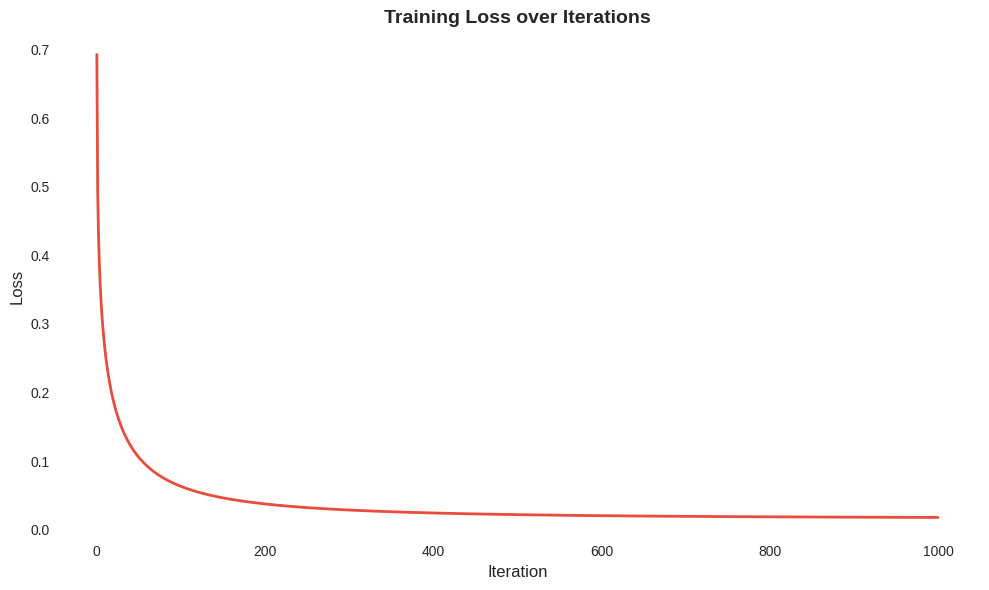

✓ Training loss curve saved!


In [23]:
# 최종 결과는 기본 임계값 0.5 사용
test_preds = model.predict(X_test)
test_metrics = classification_metrics(test_labels, test_preds)

print("\n[6/6] Generating visualizations...")
print("Using threshold = 0.5 for final results")

# 1. 학습 손실 곡선
plot_training_loss(model.loss_history, save_path='results')

print("✓ Training loss curve saved!")


## 15.시각화2- 모든 혼동 행렬

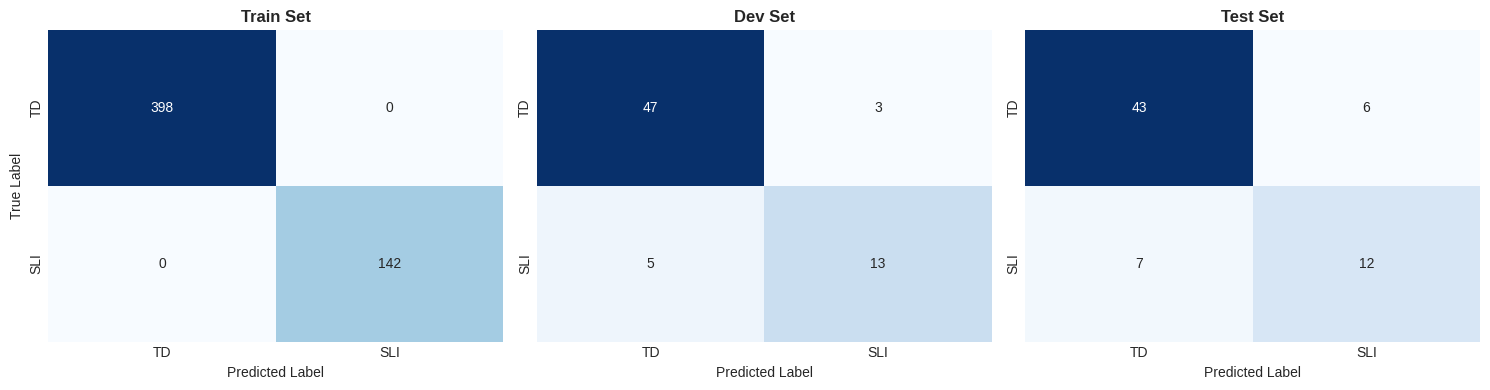

In [24]:
# 2. 모든 혼동 행렬 (Train/Dev/Test)
plot_all_confusion_matrices(
    train_metrics['confusion_matrix'],
    dev_metrics['confusion_matrix'],
    test_metrics['confusion_matrix'],
    save_path='results'
)


## 16.시각화 3- Test 혼동 행렬

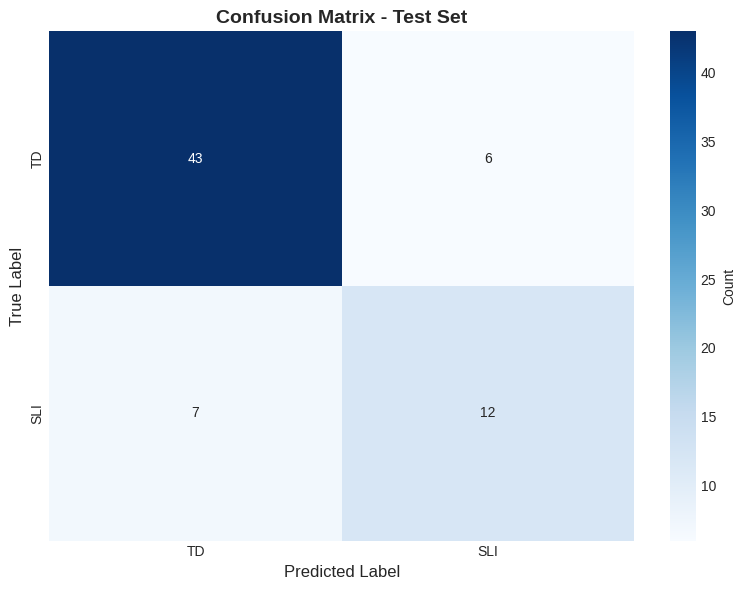

In [25]:
# 3. Test set 혼동 행렬 (크게)
plot_confusion_matrix(test_metrics['confusion_matrix'], 'Test', save_path='results')


## 17.시각화 4- 성능 비교

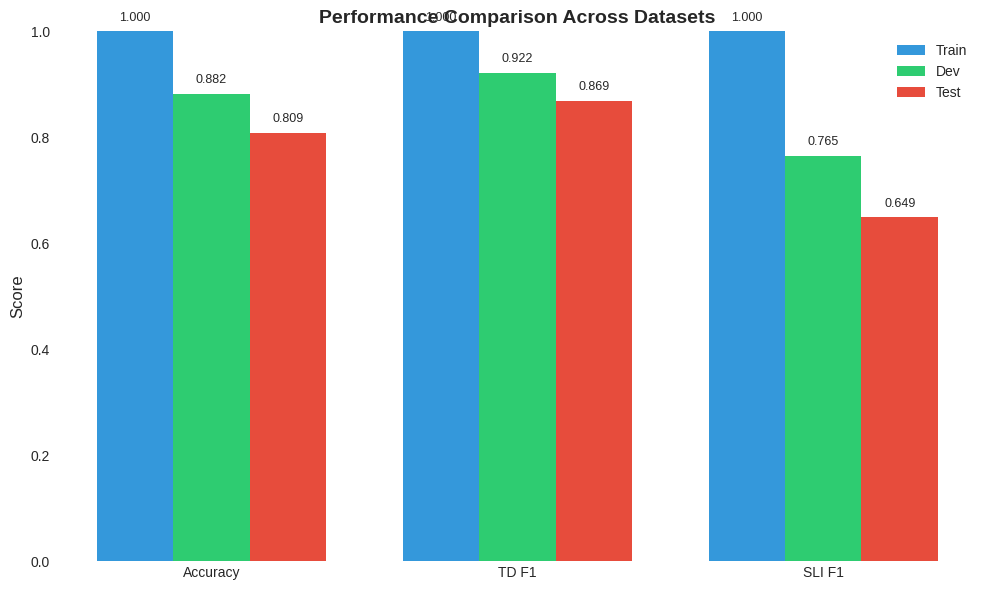

In [26]:
# 4. Train/Dev/Test 성능 비교
plot_metrics_comparison(train_metrics, dev_metrics, test_metrics, save_path='results')


## 18.시각화 5-클래스별 성능

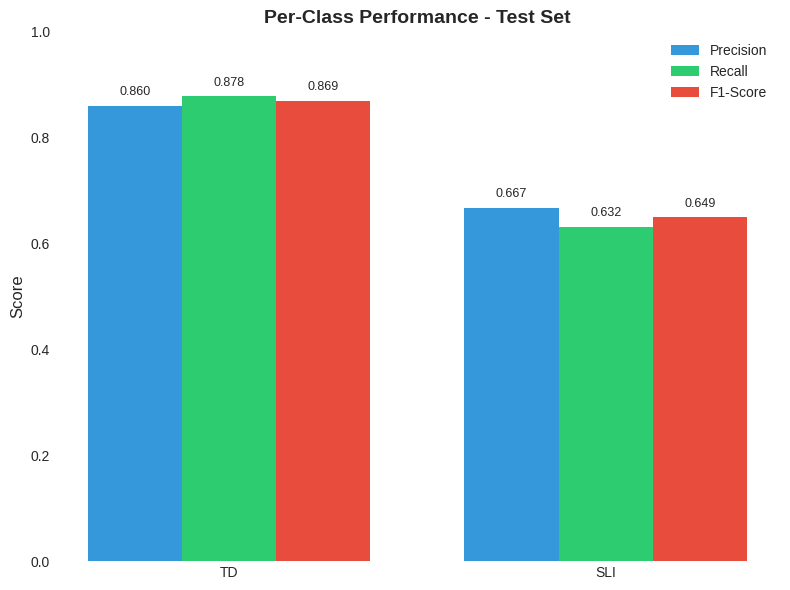

In [27]:
# 5. Test set 클래스별 성능
plot_class_performance(test_metrics, 'Test', save_path='results')


## 19.결과 저장

In [28]:
# 결과 요약 저장
with open('results_summary.txt', 'w') as f:
    f.write("Gillam SLI vs TD Classification Results\n")
    f.write("="*60 + "\n\n")
    f.write(f"Train Accuracy: {train_metrics['accuracy']:.4f}\n")
    f.write(f"Dev Accuracy: {dev_metrics['accuracy']:.4f}\n")
    f.write(f"Test Accuracy: {test_metrics['accuracy']:.4f}\n\n")

    f.write("Test Set Detailed Metrics:\n")
    f.write("-"*60 + "\n")
    f.write(f"TD  - Precision: {test_metrics['TD']['precision']:.4f}, "
            f"Recall: {test_metrics['TD']['recall']:.4f}, "
            f"F1: {test_metrics['TD']['f1']:.4f}\n")
    f.write(f"SLI - Precision: {test_metrics['SLI']['precision']:.4f}, "
            f"Recall: {test_metrics['SLI']['recall']:.4f}, "
            f"F1: {test_metrics['SLI']['f1']:.4f}\n")

print("\n" + "="*60)
print("All done! Check the generated plots.")
print("Results saved to 'results_summary.txt'")
print("="*60)

# Drive에도 결과 저장
!cp results*.png /content/drive/MyDrive/
!cp results_summary.txt /content/drive/MyDrive/
print("\nResults also saved to Google Drive!")



All done! Check the generated plots.
Results saved to 'results_summary.txt'

Results also saved to Google Drive!
